In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
my_example_nc_file = 'EUREC4A_HALO_BAHAMAS-Radiometer_20200126a.nc'
fh = Dataset(my_example_nc_file, mode='r')
df_fdir = pd.read_csv('BBR_DirectFraction_Flight_20200126a_R0.dat',skiprows = 34,delim_whitespace=True)
df_fdw = pd.read_csv('BBR_Fdn_clear_sky_Flight_20200126a_R0.dat',skiprows = 34, delim_whitespace=True)
#nav = pd.read_csv('Nav_IMS0000_02022020.Asc',skiprows=14, header=None,delim_whitespace=True)
fdw_time = df_fdw.loc[:,['sod','F_dw']]
fdir_time = df_fdir.loc[:,'f_dir']
db = pd.concat([fdw_time,fdir_time],axis=1)
db.set_index('sod',inplace=True)
time = fh.variables['TIME'][:] # time
time_bac = pd.DataFrame(time.T, columns = ['time'])
time_bac = time_bac/1000
time_bac

#print(fh.variables.keys())

,time
0,43530.0
1,43530.1
2,43530.2
3,43530.3
4,43530.4
...,...
333185,76848.5
333186,76848.6
333187,76848.7
333188,76848.8


In [2]:
fdw_time

,sod,F_dw
0,41249,178.066284
1,41369,185.633057
2,41489,193.490005
3,41609,201.247223
4,41729,208.910034
...,...,...
294,76550,107.428375
295,76670,97.549637
296,76790,84.164375
297,76910,74.633316


In [3]:
array = np.arange(41249,78030, 1) #41249 77030  333190 rows × 1 columns
arr = array.repeat(10)
df_arr = pd.DataFrame(arr, columns = ['time_arr'])
df_arr.set_index('time_arr',inplace=True)
data = df_arr.join(db)
data_int= data.interpolate(method='linear', limit_direction='forward', axis=0)
# data_int.drop(data_int.index[0:12089],inplace=True)
data_int.reset_index(inplace=True)
data_int.columns=['time','F_dw','f_dir']  #start:22810,end:355999
#data_int[data_int.time==76848]
df = data_int.iloc[22810:356000,:]
df.reset_index(inplace=True,drop=True)
df.drop(['time'],axis=1)

,F_dw,f_dir
0,325.910954,0.745247
1,325.955239,0.745336
2,325.999525,0.745426
3,326.043810,0.745515
4,326.088096,0.745605
...,...,...
333185,79.554896,0.489047
333186,79.546893,0.489012
333187,79.538891,0.488977
333188,79.530888,0.488942


In [20]:
ri = fh.variables['IRS_PHI'][:] # roll angle "deg"
#ro = pd.DataFrame(ri.T)
pi = fh.variables['IRS_THE'][:] # pitch angle "deg"
#po = pd.DataFrame(pi.T)
yi = fh.variables['IRS_HDG'][:] # yaw angle "deg"
#y = pd.DataFrame(yi.T)
szai = fh.variables['SUN_ALT'][:] # solar altitude angle
#sza = pd.DataFrame(szai.T)
saai = fh.variables['SUN_AZI'][:] # solar azimuth angle
#saa = pd.DataFrame(saai.T)
fdw = df.loc[:,'F_dw']
fdir = df.loc[:,'f_dir']
SWd = fh.variables['FDSC'][:]
SWD = pd.DataFrame(SWd.T)
SWD.columns=['swu']
r_off = 0
p_off = 0


import math
def Fdw_attitude_correction(fdw,ri,pi,yi,sza,saa,r_off,p_off,fdir):
    r = ri+r_off
    p = pi+p_off
    nd =[]
    for i in szai:
        for j in saai:
            for k in r:
                for l in p:
                    for m in yi:
                        for n in fdw:
                            for o in fdir:
                                eq1 = math.sin((90-i)*(math.pi/180))
                                eq2 = math.cos((90-i)*(math.pi/180))*math.sin(k*(math.pi/180))*math.sin((j-m)*(math.pi/180))
                                eq3 = math.cos((90-i)*(math.pi/180))*math.sin(l*(math.pi/180))
                                eq4 = math.cos(k*(math.pi/180))*math.cos((j-m)*(math.pi/180))
                                eq5 = math.sin((90-i)*(math.pi/180))*math.cos(l*(math.pi/180))*math.cos(k*(math.pi/180))
                                #factor = eq1/((eq2-eq3*(eq4+eq5))
                                factor = eq1/(eq2+eq3*eq4+eq5)
                                Fdw=o*n*factor+(1-o)*n
    return nd.append(Fdw)
Fdw_attitude_correction(fdw,ri,pi,yi,szai,saai,r_off,p_off,fdir)

# corrected_FDSC = SWD.swu + correction_weighted
# swd_correct = pd.DataFrame(corrected_FDSC)
# swd_correct.columns = ['swd_corr']
# swd_correct

KeyboardInterrupt: 

In [6]:
#data_int[data_int.time==43530]
#data_int[data_int.time==76848]
#start:22810,end:355999

In [7]:
SWu = fh.variables['FUS'][:]
LWu = fh.variables['FDL'][:]
LWd = fh.variables['FUL'][:]
SWU = pd.DataFrame(SWu.T)
LWU = pd.DataFrame(LWu.T)
LWD = pd.DataFrame(LWd.T)
df_big = pd.concat([time_bac,SWD,swd_correct,SWU,LWU,LWD],axis =1)
df_big.columns = ['Time', 'ShortWave_down','ShortWave_down_corr', 'ShortWave_up','LongWave_down', 'LongWave_up']
df_big['Time'] = df_big.loc[:,'Time'].round(1)
df_big

,Time,ShortWave_down,ShortWave_down_corr,ShortWave_up,LongWave_down,LongWave_up
0,43530.0,345.452637,667.960870,23.680618,368.315552,474.629272
1,43530.1,343.288422,665.796655,24.328846,368.933014,475.453278
2,43530.2,340.855194,663.363427,25.415541,372.147644,474.953979
3,43530.3,338.514343,661.022576,25.763048,367.793793,474.896637
4,43530.4,335.891754,658.399987,26.735828,364.747070,473.947754
...,...,...,...,...,...,...
333185,76848.5,100.857765,423.365998,10.205178,371.479187,508.992310
333186,76848.6,101.089699,423.597932,10.065176,378.944214,509.730133
333187,76848.7,102.144554,424.652787,9.876084,382.268768,510.173706
333188,76848.8,102.157036,424.665269,9.592519,375.248260,510.079895


In [22]:
df_big['Time'] = df_big.loc[:,'Time'].round(1)
df_big
f = []
for s in df_big.loc[:,'Time']:
    try:
        f.append(pd.to_datetime(s,format = "%H:%M:%S.%f" ))
    except:
        ValueError
f

[]

In [85]:
import datetime 
def convert(n): 
    return str(datetime.timedelta(seconds = n)) 
time = []
for i in df_big.Time:
    t = convert(i)
    time.append(t)
date_time = pd.DataFrame(time)
date_time.columns=['time']
df_new = pd.concat([date_time.iloc[:,0:1],df_big],axis =1)
df_new
# df_new.columns = ['time','ShortWave_UP','ShortWave_DOWN','LongWave_UP','LongWave_DOWN']

,time,Time,ShortWave_down,ShortWave_down_corr,ShortWave_up,LongWave_down,LongWave_up
0,12:05:30,43530.0,345.452637,295.699818,23.680618,368.315552,474.629272
1,12:05:30.100000,43530.1,343.288422,293.535603,24.328846,368.933014,475.453278
2,12:05:30.200000,43530.2,340.855194,291.102376,25.415541,372.147644,474.953979
3,12:05:30.300000,43530.3,338.514343,288.761525,25.763048,367.793793,474.896637
4,12:05:30.400000,43530.4,335.891754,286.138936,26.735828,364.747070,473.947754
...,...,...,...,...,...,...,...
333185,21:20:48.500000,76848.5,100.857765,51.104947,10.205178,371.479187,508.992310
333186,21:20:48.600000,76848.6,101.089699,51.336880,10.065176,378.944214,509.730133
333187,21:20:48.700000,76848.7,102.144554,52.391736,9.876084,382.268768,510.173706
333188,21:20:48.800000,76848.8,102.157036,52.404217,9.592519,375.248260,510.079895


In [70]:
# b = df_new['time'].astype(str)
# b.to_csv('df_new_time.csv',index=False)
# b_df = pd.read_csv('df_new_time.csv',header=None,sep='\.')
# b_df.iloc[:,:]

C:\Users\spark.DESKTOP-D1NJRMK\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
C:\Users\spark.DESKTOP-D1NJRMK\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,0
12:05:30,NaN
12:05:30,100000.0
12:05:30,200000.0
12:05:30,300000.0
12:05:30,400000.0
...,...
21:20:48,500000.0
21:20:48,600000.0
21:20:48,700000.0
21:20:48,800000.0


In [72]:
# import datetime 
# def convert(n): 
#     return str(datetime.timedelta(seconds = n)) 
# time = []
# for i in df_big.Time:
#     t = convert(i)
#     try:
#         c = datetime.datetime.strptime(t, "%H:%M:%S")
#     except:
#         ValueError
#     time.append(c)
# date_time = pd.DataFrame(time)
# date_time.columns=['time']
# df_new = pd.concat([date_time.iloc[:,0:1],df_big],axis =1)
# df_new
#df_new.to_csv('')
# df_new.columns = ['time','ShortWave_UP','ShortWave_DOWN','LongWave_UP','LongWave_DOWN']

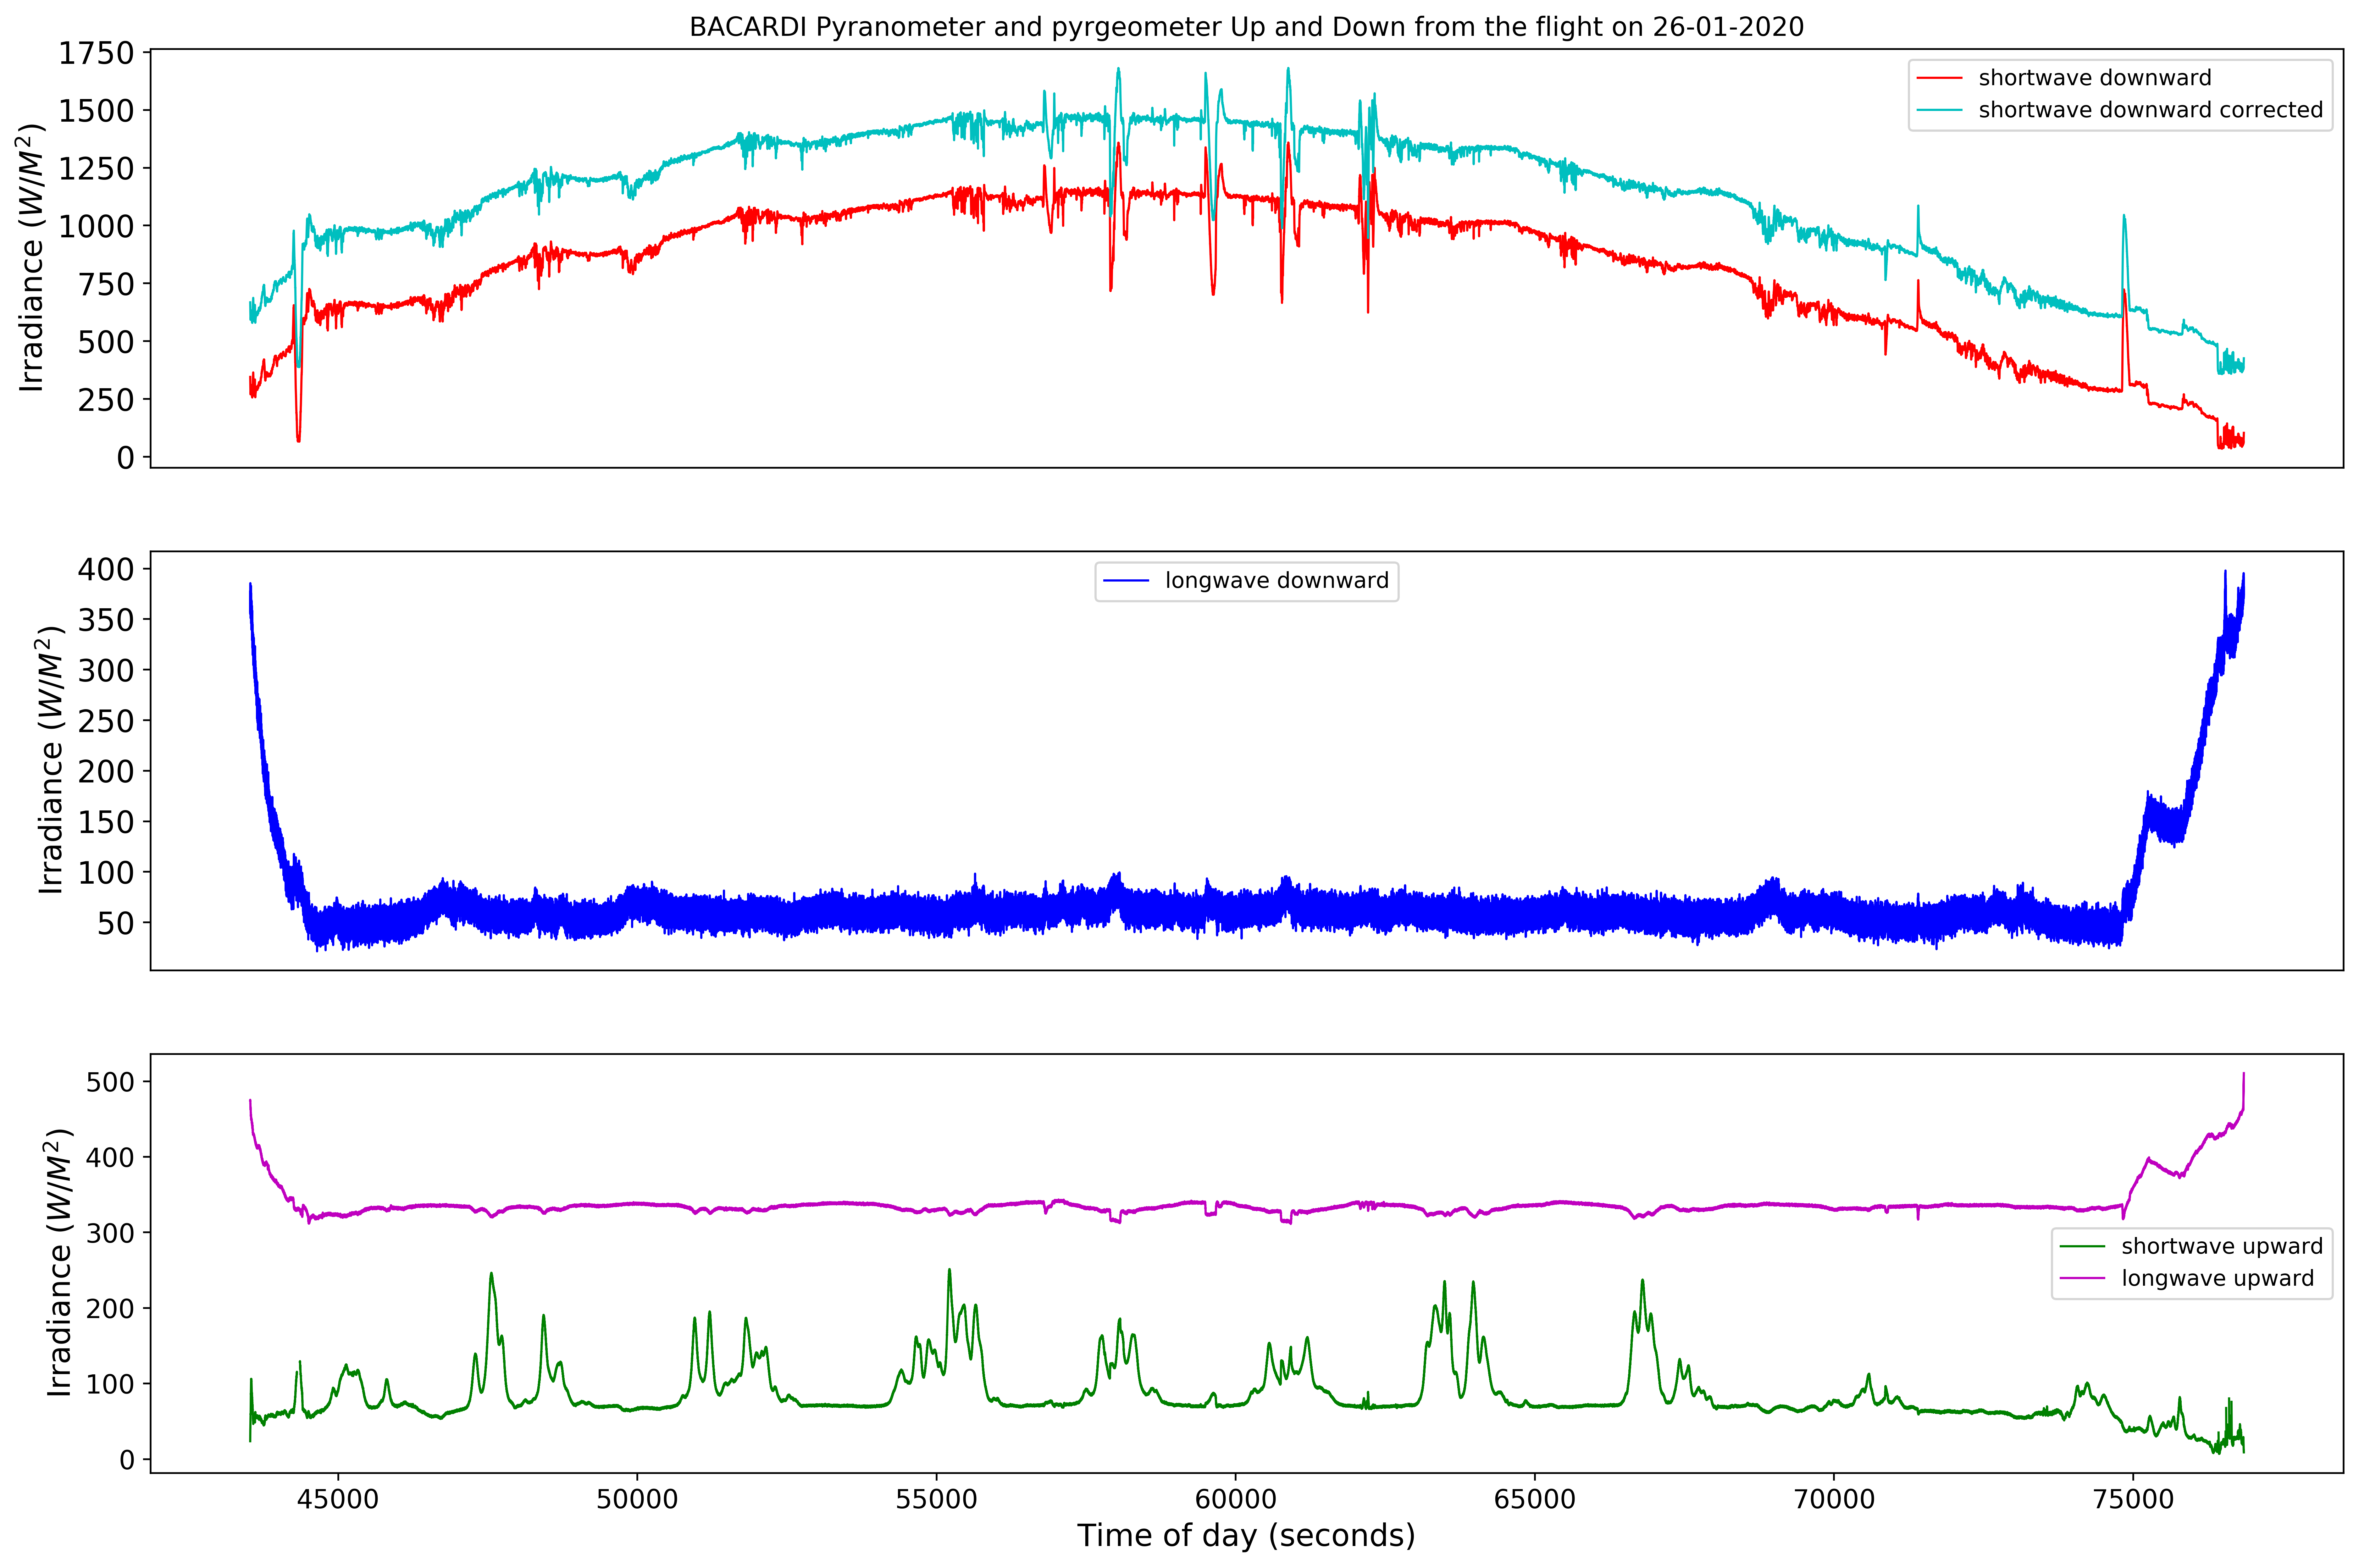

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
#df_new_24jan = pd.read_csv('df_new_24jan.csv')
plt.figure(figsize=(18,12),dpi=500)
plt.subplot(311)
plt.plot(df_big.Time,df_big.ShortWave_down, 'r', label = 'shortwave downward',linewidth=1)
plt.plot(df_big.Time,df_big.ShortWave_down_corr, 'c', label = 'shortwave downward corrected',linewidth=1)
plt.title('BACARDI Pyranometer and pyrgeometer Up and Down from the flight on 26-01-2020')
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xticks([], [])
plt.yticks(fontsize=14)
plt.legend(fontsize=10)
plt.subplot(312)
plt.plot(df_big.Time,df_big.LongWave_down, 'b', label = 'longwave downward',linewidth=1)
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xticks([], [])
plt.yticks(fontsize=14)
plt.legend(fontsize=10)
plt.subplot(313)
plt.plot(df_big.Time,df_big.ShortWave_up, 'g', label = 'shortwave upward',linewidth=1)
plt.plot(df_big.Time,df_big.LongWave_up, 'm', label = 'longwave upward',linewidth=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xlabel('Time of day (seconds)',fontsize=14)
plt.legend(fontsize=10)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
#df_new_24jan = pd.read_csv('df_new_24jan.csv')
plt.figure(figsize=(18,12),dpi=500)
plt.subplot(311)
plt.plot(df_new.time,df_new.ShortWave_down, 'r', label = 'shortwave downward',linewidth=1)
plt.plot(df_new.time,df_new.ShortWave_down_corr, 'c', label = 'shortwave downward corrected',linewidth=1)
plt.title('BACARDI Pyranometer and pyrgeometer Up and Down from the flight on 26-01-2020')
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xticks([], [])
plt.yticks(fontsize=14)
plt.legend(fontsize=10)
plt.subplot(312)
plt.plot(df_new.time,df_new.LongWave_down, 'b', label = 'longwave downward',linewidth=1)
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xticks([], [])
plt.yticks(fontsize=14)
plt.legend(fontsize=10)
plt.subplot(313)
plt.plot(df_new.time,df_new.ShortWave_up, 'g', label = 'shortwave upward',linewidth=1)
plt.plot(df_new.time,df_new.LongWave_up, 'm', label = 'longwave upward',linewidth=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xlabel('Times of day (s)',fontsize=14)
plt.legend(fontsize=10)
plt.show()